100%|██████████| 9912422/9912422 [00:00<00:00, 235730063.19it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 36063022.87it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 60092202.46it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6649399.22it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/50], Loss D: 0.6331, Loss G: 1.2641
Epoch [2/50], Loss D: 0.6679, Loss G: 2.0882
Epoch [3/50], Loss D: 0.9639, Loss G: 1.3774
Epoch [4/50], Loss D: 1.1755, Loss G: 0.8096
Epoch [5/50], Loss D: 0.6908, Loss G: 2.2661
Epoch [6/50], Loss D: 0.7456, Loss G: 1.8941
Epoch [7/50], Loss D: 0.8397, Loss G: 2.4286
Epoch [8/50], Loss D: 0.7670, Loss G: 1.8553
Epoch [9/50], Loss D: 0.7903, Loss G: 2.3219
Epoch [10/50], Loss D: 0.5864, Loss G: 1.3413
Epoch [11/50], Loss D: 0.7031, Loss G: 2.5600
Epoch [12/50], Loss D: 0.6443, Loss G: 2.6589
Epoch [13/50], Loss D: 0.6938, Loss G: 2.5005
Epoch [14/50], Loss D: 0.4629, Loss G: 3.1323
Epoch [15/50], Loss D: 0.5454, Loss G: 2.1538
Epoch [16/50], Loss D: 0.6237, Loss G: 2.0670
Epoch [17/50], Loss D: 0.3416, Loss G: 3.0729
Epoch [18/50], Loss D: 0.5532, Loss G: 2.1070
Epoch [19/50], Loss D: 0.5760, Loss G: 2.2299
Epoch [20/50], Loss D: 0.5068, Loss G: 2.5520
Epoch [21/50],

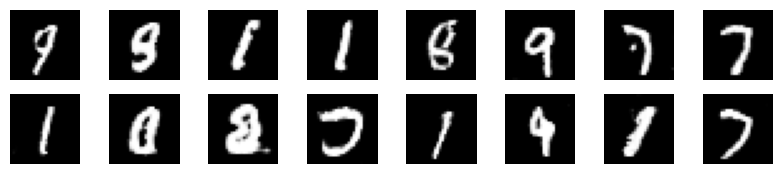

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 设置随机种子
torch.manual_seed(42)

#使用转置卷积优化生成器
class GeneratorWithConv(nn.Module):
    def __init__(self):
        super(GeneratorWithConv, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 64, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)
    
    
# 定义判别器网络
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)

        self.fc2 = nn.Linear(128, 1)

        self.relu = nn.ReLU()

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = self.relu(self.conv1(x))

        x = self.pool(x)

        x = self.relu(self.conv2(x))

        x = self.pool(x)

        x = x.view(-1, 64 * 7 * 7)
        #逆向
        #tensor.view(batch_size,64,7,7)

        x = self.relu(self.fc1(x))

        x = self.sigmoid(self.fc2(x))

        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 设置数据转换,并对数据进行归一化处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载MNIST数据集
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)  # shuffle:是否打乱顺序

# 初始化生成器和判别器
generator = GeneratorWithConv().to(device)
discriminator = Discriminator().to(device)

# 定义损失函数和优化器
criterion = nn.BCELoss().to(device)
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# 训练 GAN
num_epochs = 50

for epoch in range(num_epochs):
    for real_images, _ in data_loader:
        batch_size = real_images.size(0)
        #real_images = real_images.view(batch_size, -1).to(device)  # 改变张量的形状

        # 训练判别器
        optimizer_d.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        # 判别器对真实样本的损失
        output_real = discriminator(real_images)
        loss_real = criterion(output_real, real_labels)

        # 生成器生成假样本并计算判别器对假样本的损失
        #z = torch.randn(batch_size, 100).to(device)
        z = torch.randn((batch_size, 100, 1, 1)).to(device)
        fake_images = generator(z)
        #fake_images = fake_images.view(batch_size,1,28,28)
        output_fake = discriminator(fake_images.detach())
        loss_fake = criterion(output_fake, fake_labels)

        # 总体判别器的损失
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()

        # 训练生成器
        optimizer_g.zero_grad()
        output = discriminator(fake_images)
        loss_g = criterion(output, real_labels)
        loss_g.backward()
        optimizer_g.step()

    # 输出每个epoch的损失
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}')

# 生成手写数字示例
with torch.no_grad():
    z_sample = torch.randn((16, 100,1,1)).to(device)
    generated_samples = generator(z_sample).cpu().numpy()
    #generated_samples = generator(z_sample).view(-1, 28, 28).cpu().numpy()

# 显示生成的手写数字示例
plt.figure(figsize=(10, 2))
for i in range(16):
    plt.subplot(2, 8, i + 1)
    plt.imshow(generated_samples[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


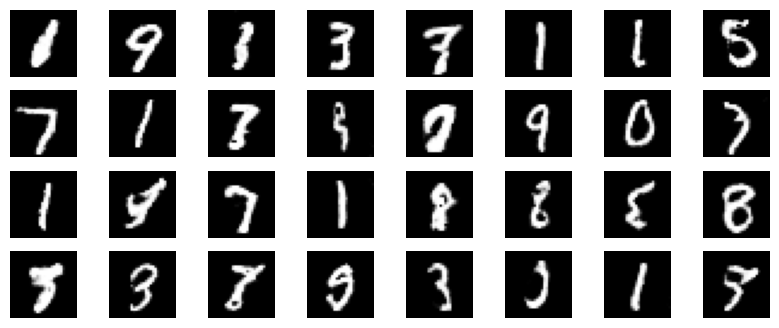

In [5]:
# 生成手写数字示例
with torch.no_grad():
    z_sample = torch.randn((32, 100,1,1)).to(device)
    generated_samples = generator(z_sample).cpu().numpy()
    #generated_samples = generator(z_sample).view(-1, 28, 28).cpu().numpy()

# 显示生成的手写数字示例
plt.figure(figsize=(10, 4))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(generated_samples[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()
